<a href="https://colab.research.google.com/github/night00white/python-fa20/blob/master/GoL_GA(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Game of Life w/ Genetic Algorithm



---
## Code

### Game of Life

In [ ]:
import numpy as np
def gol_update(X):
    """Game of life step using scipy tools"""
    from scipy.signal import convolve2d
    nbrs_count = convolve2d(X, np.ones((3, 3)), mode='same', boundary='fill') - X
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

def make_move(field, moves=1):
    """
    Make a move forward according to Game of Life rules
    """
    for i in range(moves):
      field=gol_update(field)
    return field

### Genatic Algorithm

In [ ]:
def generate_population(size,r=5,c=5, random_state=-1):
    """
    Generating initial population of individual solutions
    :return: initial population as a list of 10x10 arrays
    """
    if random_state != -1:
        np.random.seed(random_state)
    initial_states = np.split(np.random.binomial(1, 0.5, (r * size, c)).astype('uint8'), size)
    return initial_states

In [ ]:
def fitness(start_field, end_field, delta):
    """
    Calculate fitness for particular candidate (start configuration of the field)
    :param start_field: candidate (start configuration)
    :param end_field: target (stop configuration)
    :param delta: number of steps to proceed before comparing to stop configuration
    :return: value in range [0, 1] that indicates fractions of cells that match their state
    """
    candidate = make_move(start_field, moves=delta)
    return (candidate == end_field).sum() / len(end_field)/len(end_field[0])

def score_population(population, target, delta):
    """
    Apply fitness function for each gene in a population
    :param population: list of candidate solutions
    :param target: 10x10 array that represents field in stopping condition
    :param delta: number of steps to revert
    :return: list of scores for each solution
    """
    return [fitness(gene, target, delta) for gene in population]

In [ ]:
def selection(population, scores, retain_frac=0.85, retain_random=0.05):
    """
    Apply selection operator to the population
    :param population: list of candidate solutions
    :param scores: list of score associated with each individual
    :param retain_frac: percent of top individuals to retain
    :param retain_random: chance of retaining sub-optimal individuals in the population
    """
    retain_len = int(len(scores) * retain_frac)
    sorted_indices = np.argsort(scores)[::-1]
    population = [population[idx] for idx in sorted_indices]
    selected = population[:retain_len]
    leftovers = population[retain_len:]
    
    for gene in leftovers:
        if np.random.rand() < retain_random:
            selected.append(gene)     
    return selected

In [ ]:
def mutate(field, switch_frac=1):
    """ Inplace mutation of the provided field """
    a = np.random.binomial(1, switch_frac, size=(len(field), len(field[0]))).astype('bool')
    field[a] += 1
    field[a] %= 2
    return field

In [ ]:
def crossover(mom, dad):
    """ Take two parents, return two children, interchanging half of the allels of each parent randomly """
    select_mask = np.random.binomial(1, 0.5, size=(len(mom), len(mom[0]))).astype('bool')
    child1, child2 = np.copy(mom), np.copy(dad)
    child1[select_mask] = dad[select_mask]
    child2[select_mask] = mom[select_mask]
    return child1, child2

In [ ]:
def evolve(population, target, delta, retain_frac=0.75, retain_random=0.05, mutate_chance=0.05,mutate_switch_frac=1,immigrants=0):
    """
    Evolution step
    :param Y: 20x20 array that represents field in stopping condition
    :param delta: number of steps to revert
    :return: new generation of the same size
    """
    scores = score_population(population, target, delta)
    next_population = selection(population, scores, retain_frac=retain_frac, retain_random=retain_random)
    
    # mutate everyone expecting for the best candidate
    for gene in next_population[1:]:
        if np.random.rand() < mutate_chance:
            mutate(gene,mutate_switch_frac)
 
    places_left = len(population) - len(next_population)
    children = []
    parent_max_idx = len(next_population) - 1
    while len(children) < places_left:
        mom_idx, dad_idx = np.random.randint(0, parent_max_idx, 2)
        if mom_idx != dad_idx:
            child1, child2 = crossover(next_population[mom_idx], next_population[dad_idx])
            children.append(child1)
            if len(children) < places_left:
                children.append(child2)
    next_population.extend(children)

    if immigrants>0:
        next_population.extend(generate_population(int(immigrants*len(scores)),r=len(target),c=len(target[0])))   
    return next_population

In [ ]:
def solve(target, delta,population_size=300, n_generations=700,random_state=-1):
    """
    :param target: 20x20 array that represents field in stopping condition
    :param delta: number of steps to revert
    :param n_generations: number of evolution generations. Overrides initialization value if specified
    :return: 20x20 array that represents the best start field found and associated fitness value
    """
    fitnessList=[]
    bestPatternList=[]

    # initialize population
    population = generate_population(population_size,r=len(target),c=len(target[0]),random_state=random_state)
    
    # evolution
    for generation in range(n_generations):
        population = evolve(population, target, delta,mutate_chance=0.05,mutate_switch_frac=0.9)
        
        fitnessList.append(fitness(population[0], target, delta))
        bestPatternList.append(population[0])
        # if generation == 0:
        #     # print("Generation #: best score")
        #if generation % 1 == 0:
        print("Generation ", generation, ",best score: ", fitness(population[0], target, delta))
        
        #if generation>200 and fitnessList[generation]==fitnessList[generation-200] and generation%100==0:
#       hypermutation!
            #population = evolve(population, target, delta,immigrants=1,mutate_chance=0.5,mutate_switch_frac=0.9)
            #if (len(population)>population_size*5):
             # population=population[:population_size*5]
            #print("=>immigrants inserted!")
#         if fitness(population[0], target, delta)==1:
# #             success
#             print("Generation ", generation, ", final best score: ", fitness(population[0], target, delta))
#             return (bestPatternList,fitnessList)
#         if generation>400 and fitnessList[generation]==fitnessList[generation-400]:
# #             fail
#             print("Generation ", generation, ", final best score: ", fitness(population[0], target, delta))
#             return (bestPatternList,fitnessList)
        print("Generation ", generation, ", final best score: ", fitness(population[0], target, delta))
    return (bestPatternList,fitnessList)

### Display

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
def display_pattern(X,dpi=5):
    # figure config
    figsize = (len(X) * 5. / dpi, len(X[0]) * 5. / dpi)
    cmap = colors.ListedColormap(['white', 'black'])
    fig, ax = plt.subplots(figsize=figsize)
    im=ax.imshow(X, cmap=cmap)
    
    #set x and y ticks and labels
    plt.xticks(range(len(X[0])), range(len(X[0])))
    plt.yticks(range(len(X)), range(len(X)-1,-1,-1));
 
    #set minor axes in between the labels
    ax=plt.gca()
    ax.set_xticks([x-0.5 for x in range(1,len(X[0]))],minor=True )
    ax.set_yticks([y-0.5 for y in range(1,len(X))],minor=True)
    #plot grid on minor axes
    plt.grid(which="minor",ls="-",lw=2)
    return ax

In [ ]:
def disp_target_result(target,result,delta,animate=0):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
    fig.tight_layout()
    X=target
    ax[0].set_xticks(range(len(X[0])), range(len(X[0])))
    ax[0].set_yticks(range(len(X)), range(len(X)-1,-1,-1))
    ax[ 1].set_xticks(range(len(X[0])), range(len(X[0])))
    ax[1].set_yticks(range(len(X)), range(len(X)-1,-1,-1))
    ax[0].imshow(target, cmap=plt.cm.Greys)
    ax[ 0].set_title("Target end field")
    ax[1].imshow(make_move(result, moves=delta), cmap=plt.cm.Greys)
    ax[ 1].set_title("GA solution end field\nfitness="+"{:.2f}".format(fitness(result, target, delta)))
 
#!/usr/bin/env python -W ignore::DeprecationWarning
 
# fig.savefig('solution_example.png', dpi=25, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
from matplotlib import animation
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import HTML

# run function
def life_animation(Xs, dpi=10, frames=10, interval=300, mode='loop',delta=0,gens=[]):
  # Xs: a list of game of life patterns
 
    X = np.asarray(Xs[0])
    X = X.astype(bool)
    X_blank = np.zeros_like(X)
    
    # figure config
    figsize = (X.shape[0] * 5. / dpi, X.shape[1] * 5. / dpi)
    cmap = colors.ListedColormap(['white', 'black'])
    fig, ax = plt.subplots(figsize=figsize)
    im=ax.imshow(X, cmap=cmap)
    
    #set x and y ticks and labels
    plt.xticks(range(X.shape[1]), range(X.shape[1]))
    plt.yticks(range(X.shape[0]), range(X.shape[0]-1,-1,-1));
 
    #set minor axes in between the labels
    ax=plt.gca()
    ax.set_xticks([x-0.5 for x in range(1,X.shape[1])],minor=True )
    ax.set_yticks([y-0.5 for y in range(1,X.shape[0])],minor=True)
    ax.set_title("generation "+str(gens[0]))
    #plot grid on minor axes
    plt.grid(which="minor",ls="-",lw=2)
 
    # initialization function: plot the background of each frame
    def init():
        im.set_data(X_blank)
 
    # animation function.  This is called sequentially
    def animate(i):
        im.set_data(make_move(animate.Xs[i], moves=delta))
        ax.set_title("generation "+str(gens[i]))
        animate.X = Xs[i]
    
    animate.Xs = Xs
    return animation.FuncAnimation(fig, animate, init_func=init,frames=frames, interval=interval)

---
## Experiment

### one simple example

Streaming output truncated to the last 5000 lines.
Generation  500 , final best score:  0.99
Generation  501 ,best score:  0.99
Generation  501 , final best score:  0.99
Generation  502 ,best score:  0.99
Generation  502 , final best score:  0.99
Generation  503 ,best score:  0.99
Generation  503 , final best score:  0.99
Generation  504 ,best score:  0.99
Generation  504 , final best score:  0.99
Generation  505 ,best score:  0.99
Generation  505 , final best score:  0.99
Generation  506 ,best score:  0.99
Generation  506 , final best score:  0.99
Generation  507 ,best score:  0.99
Generation  507 , final best score:  0.99
Generation  508 ,best score:  0.99
Generation  508 , final best score:  0.99
Generation  509 ,best score:  0.99
Generation  509 , final best score:  0.99
Generation  510 ,best score:  0.99
Generation  510 , final best score:  0.99
Generation  511 ,best score:  0.99
Generation  511 , final best score:  0.99
Generation  512 ,best score:  0.99
Generation  512 , final b

Text(0.5, 1.0, 'result')

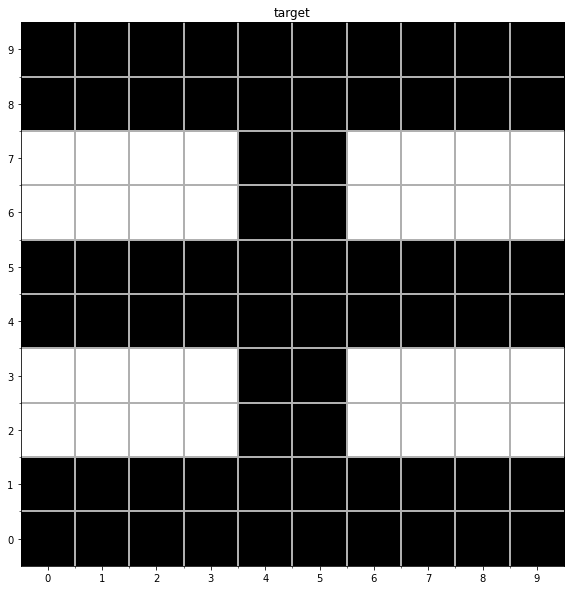

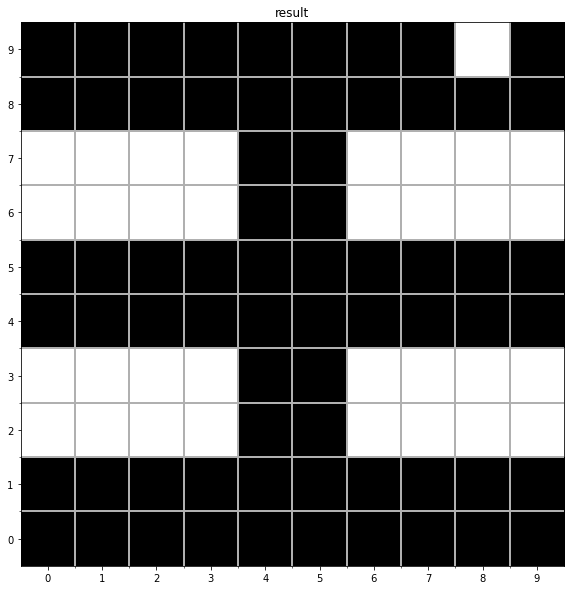

In [ ]:
target= [
    [1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1],
]
delta=0
# target=make_move(target,20)

ax=display_pattern(target)
ax.set_title("target")

result = solve(target, delta=delta, 
                  population_size=100,n_generations=3000,
                   random_state=1)

ax=display_pattern(make_move(result[0][-1],delta))
ax.set_title("result")




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

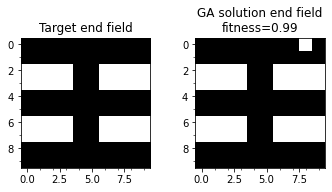

In [ ]:
# compare "target" vs "the best match after delta updates"
disp_target_result(target,result[0][-1],delta)

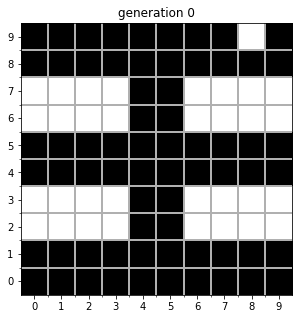

In [ ]:
# Game of Life updates of the best match in the last GA generation
pattern_updates=[]
for gol_gen in range(delta+1):
    pattern_updates.append(make_move(result[0][-1],gol_gen))

HTML(life_animation(pattern_updates, dpi=10, frames=len(pattern_updates), mode='once',gens=range(delta+1)).to_jshtml())

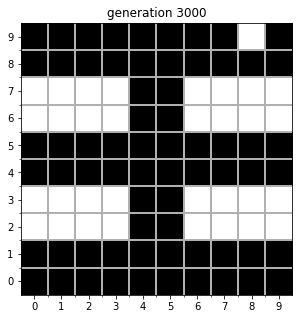

In [ ]:
# the process of learning/evolution

if len(result[0])<10:
    frames=len(result[0])
else:
    frames=50
gens_disp=list(range(0,len(result[0]),int(len(result[0])/frames)))
gens_disp.append(len(result[0]))

patterns_disp= result[0][slice(0,len(result[0]),int(len(result[0])/frames))]
patterns_disp.append(result[0][-1])

HTML(life_animation(patterns_disp,
                    frames=len(patterns_disp),delta=delta, 
                    gens=gens_disp,
                    dpi=10, mode='once').to_jshtml())

### expriment with GA generation

In [ ]:
import time
 
gen_performance_data=[]

for gen in range(100,1000,10):
    start = time.time()
    target=[
    [1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1],
]
    print(">>>>>>>\n n_generations=",gen,"\n")
    target=make_move(target,5)
    result = solve(target, delta=5, 
                  population_size=100,n_generations=gen,
                   random_state=1)
    end = time.time()
    gen_performance_data.append(end-start)

Streaming output truncated to the last 5000 lines.
Generation  443 , final best score:  0.9099999999999999
Generation  444 ,best score:  0.9099999999999999
Generation  444 , final best score:  0.9099999999999999
Generation  445 ,best score:  0.9099999999999999
Generation  445 , final best score:  0.9099999999999999
Generation  446 ,best score:  0.9099999999999999
Generation  446 , final best score:  0.9099999999999999
Generation  447 ,best score:  0.9099999999999999
Generation  447 , final best score:  0.9099999999999999
Generation  448 ,best score:  0.9099999999999999
Generation  448 , final best score:  0.9099999999999999
Generation  449 ,best score:  0.9099999999999999
Generation  449 , final best score:  0.9099999999999999
Generation  450 ,best score:  0.9099999999999999
Generation  450 , final best score:  0.9099999999999999
Generation  451 ,best score:  0.9099999999999999
Generation  451 , final best score:  0.9099999999999999
Generation  452 ,best score:  0.9099999999999999
Gene

In [ ]:
### expriment with target size

In [ ]:
dim_performance_data=[]

for dim in range(5,300):
    start = time.time()
    
    target=generate_population(1,r=dim,c=dim)[0]
    target=make_move(target,1)
    print("-------------------------\nboard size:%d\ntarget=\n" %dim,target )
    result = solve(target, delta=1, 
                  population_size=100,n_generations=100)
    end = time.time()
    dim_performance_data.append(end-start)



Streaming output truncated to the last 5000 lines.
Generation  15 , final best score:  0.6100871665616467
Generation  16 ,best score:  0.6100871665616467
Generation  16 , final best score:  0.6100871665616467
Generation  17 ,best score:  0.6100871665616467
Generation  17 , final best score:  0.6100871665616467
Generation  18 ,best score:  0.6100871665616467
Generation  18 , final best score:  0.6100871665616467
Generation  19 ,best score:  0.6100871665616467
Generation  19 , final best score:  0.6100871665616467
Generation  20 ,best score:  0.6100871665616467
Generation  20 , final best score:  0.6100871665616467
Generation  21 ,best score:  0.6100871665616467
Generation  21 , final best score:  0.6100871665616467
Generation  22 ,best score:  0.6100871665616467
Generation  22 , final best score:  0.6100871665616467
Generation  23 ,best score:  0.6102053140096618
Generation  23 , final best score:  0.6102053140096618
Generation  24 ,best score:  0.6113999159840369
Generation  24 , final

---

### Analysis

#### Results


#### Performance

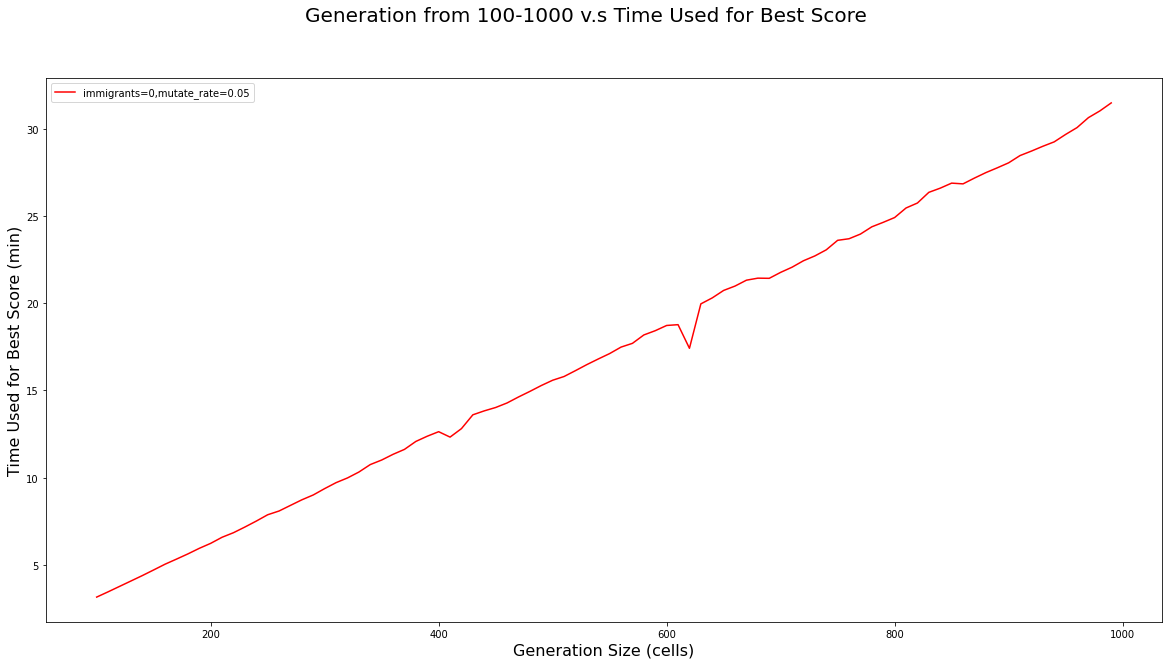

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
x=np.arange(100,1000,10)
 
fig=plt.figure(figsize=(20, 10))
fig.show()
ax=fig.add_subplot(111)
 
 
ax.plot(x,gen_performance_data,c='r',label='immigrants=0,mutate_rate=0.05')

# ax.plot(x,gen_performance_data,'o',c='r',label='immigrants=0,mutate_rate=0.05')
# ax.plot(x,x*0.01,c='b',label='base')
 
# ax.plot(x,x**2-1,c='m',marker="o",ls='--',label='BSwap',fillstyle='none')
# ax.plot(x,x-1,c='k',marker="+",ls=':',label='MSD')
 
plt.legend(loc=2)
plt.ylabel('Time Used for Best Score (min)', fontsize=16)
plt.xlabel('Generation Size (cells)', fontsize=16)
plt.suptitle('Generation from 100-1000 v.s Time Used for Best Score', fontsize=20)
plt.draw()


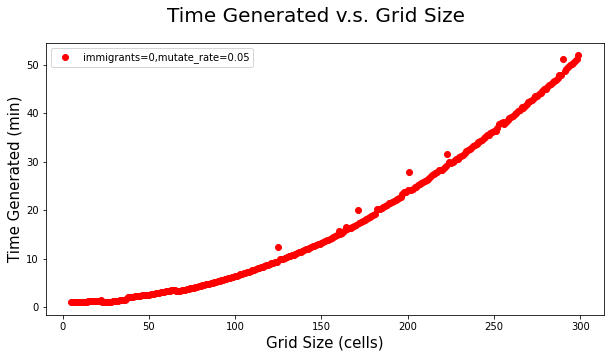

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
x=np.arange(5,300)
 
fig=plt.figure(figsize=(10, 5))
fig.show()
ax=fig.add_subplot(111)
 
 

ax.plot(x,dim_performance_data,'o',c='r',label='immigrants=0,mutate_rate=0.05')
# ax.plot(x,x*0.01,c='b',label='base')
 
# ax.plot(x,x**2-1,c='m',marker="o",ls='--',label='BSwap',fillstyle='none')
# ax.plot(x,x-1,c='k',marker="+",ls=':',label='MSD')
 
plt.legend(loc=2)
plt.ylabel('Time Generated (min)',fontsize=15)
plt.xlabel('Grid Size (cells)', fontsize=15)
plt.suptitle('Time Generated v.s. Grid Size',fontsize=20)
plt.draw()

#### Evolution